In [4]:
!pip install torch torchvision transformers
!pip install ftfy regex tqdm
!pip install datasets transformers torch torchvision ftfy regex tqdm scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 18.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.0
    Uninstalling fsspec-2025.3.0:
      Successfully uninstalled fsspec-2025.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.0 requires fsspec==2025.3.0, but you have fsspec 2024.12.0 which is incompatible.


## Step 1. Download and Preprocess CIFAR-10

In [5]:
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

## 2. Step 2. Load CLIP and Encode the Dataset

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from datasets import load_dataset
from transformers import CLIPProcessor, CLIPModel
import random
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np
from PIL import Image
import torchvision.transforms as transforms

device = "cuda" if torch.cuda.is_available() else "cpu"

to_pil = transforms.ToPILImage()

def collate_fn(batch):
    images = []
    for item in batch:
        img = item['img']
        # If the image is not already a PIL image, convert it.
        if not isinstance(img, Image.Image):
            # If it is a tensor, rescale if needed (from [-1,1] to [0,1])
            if isinstance(img, torch.Tensor):
                if img.min() < 0 or img.max() > 1:
                    img = (img + 1) / 2.0  # Rescale tensor values to [0,1]
                img = to_pil(img)
        images.append(img)
    labels = [item['label'] for item in batch]
    return images, torch.tensor(labels)

dataset = load_dataset("cifar10")

# Create DataLoaders with shuffle=False to preserve order
train_loader = DataLoader(dataset['train'], batch_size=64, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(dataset['test'], batch_size=64, shuffle=False, collate_fn=collate_fn)

README.md:   0%|          | 0.00/5.16k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/120M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/23.9M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [7]:
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

In [8]:
# Function to encode images using CLIP's image encoder.
def encode_dataset(loader):
    model.eval()
    representations = []
    labels_list = []
    with torch.no_grad():
        for images, targets in loader:
            # The processor handles resizing and normalization.
            inputs = processor(images=images, return_tensors="pt", padding=True).to(device)
            outputs = model.get_image_features(**inputs)
            representations.append(outputs.cpu())
            labels_list.append(targets)
    return torch.cat(representations), torch.cat(labels_list)

# Encode both training and test sets
train_reps, train_labels = encode_dataset(train_loader)
test_reps, test_labels = encode_dataset(test_loader)

In [9]:
# Function to compute the relative representation using cosine similarity.
def compute_relative_representation(features, anchors):
    # Normalize features and anchors for cosine similarity computation
    features_norm = features / features.norm(dim=1, keepdim=True)
    anchors_norm = anchors / anchors.norm(dim=1, keepdim=True)
    return torch.matmul(features_norm, anchors_norm.T)

# Select a fixed number of anchors (e.g., 100) from the training representations
num_anchors = 100
random.seed(42)
anchor_indices = random.sample(range(train_reps.size(0)), num_anchors)
anchors = train_reps[anchor_indices]  # shape: (num_anchors, feature_dim)

# Compute the relative representations for training and test sets
train_rel_reps = compute_relative_representation(train_reps, anchors)
test_rel_reps = compute_relative_representation(test_reps, anchors)

In [10]:
# Define and train a linear classifier on the relative representations.
classifier = nn.Linear(train_rel_reps.size(1), 10)  # 10 classes for CIFAR-10
classifier.to(device)

# Create TensorDatasets for the relative representations
train_dataset_rel = TensorDataset(train_rel_reps, train_labels)
test_dataset_rel = TensorDataset(test_rel_reps, test_labels)

train_loader_rel = DataLoader(train_dataset_rel, batch_size=64, shuffle=True)
test_loader_rel = DataLoader(test_dataset_rel, batch_size=64, shuffle=False)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier.parameters(), lr=0.001)
num_epochs = 20

for epoch in range(num_epochs):
    classifier.train()
    epoch_loss = 0
    for inputs, targets in train_loader_rel:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = classifier(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/len(train_loader_rel):.4f}")

Epoch 1/20, Loss: 2.1764
Epoch 2/20, Loss: 1.9303
Epoch 3/20, Loss: 1.7425
Epoch 4/20, Loss: 1.5927
Epoch 5/20, Loss: 1.4703
Epoch 6/20, Loss: 1.3695
Epoch 7/20, Loss: 1.2817
Epoch 8/20, Loss: 1.2073
Epoch 9/20, Loss: 1.1422
Epoch 10/20, Loss: 1.0838
Epoch 11/20, Loss: 1.0334
Epoch 12/20, Loss: 0.9881
Epoch 13/20, Loss: 0.9479
Epoch 14/20, Loss: 0.9115
Epoch 15/20, Loss: 0.8777
Epoch 16/20, Loss: 0.8485
Epoch 17/20, Loss: 0.8207
Epoch 18/20, Loss: 0.7957
Epoch 19/20, Loss: 0.7727
Epoch 20/20, Loss: 0.7517


In [11]:
# Evaluate the classifier on the test set.
classifier.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, targets in test_loader_rel:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = classifier(inputs)
        _, predicted = torch.max(outputs, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

Test Accuracy: 83.20%


Anchors: 25, Test Accuracy: 72.83%
Anchors: 50, Test Accuracy: 78.24%
Anchors: 100, Test Accuracy: 84.16%
Anchors: 200, Test Accuracy: 87.67%


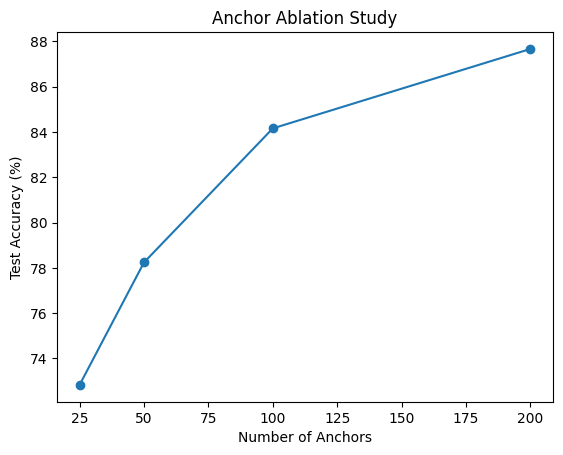

In [13]:
# Anchor Ablation Study: Vary the number of anchors and record test accuracy.
anchor_numbers = [25, 50, 100, 200]
accuracies = []

for num in anchor_numbers:
    random.seed(42)  # Ensure reproducibility
    anchor_indices = random.sample(range(train_reps.size(0)), num)
    anchors = train_reps[anchor_indices]
    train_rel = compute_relative_representation(train_reps, anchors)
    test_rel = compute_relative_representation(test_reps, anchors)

    # Train a new classifier for each anchor configuration
    clf = nn.Linear(train_rel.size(1), 10).to(device)
    train_ds = TensorDataset(train_rel, train_labels)
    test_ds = TensorDataset(test_rel, test_labels)
    train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)
    test_dl = DataLoader(test_ds, batch_size=64, shuffle=False)

    crit = nn.CrossEntropyLoss()
    opt = optim.Adam(clf.parameters(), lr=0.001)

    for epoch in range(num_epochs):
        clf.train()
        for inputs, targets in train_dl:
            inputs, targets = inputs.to(device), targets.to(device)
            opt.zero_grad()
            outputs = clf(inputs)
            loss = crit(outputs, targets)
            loss.backward()
            opt.step()

    # Evaluate the classifier for this anchor configuration
    clf.eval()
    corr = 0
    tot = 0
    with torch.no_grad():
        for inputs, targets in test_dl:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = clf(inputs)
            _, predicted = torch.max(outputs, 1)
            tot += targets.size(0)
            corr += (predicted == targets).sum().item()
    acc = 100 * corr / tot
    accuracies.append(acc)
    print(f"Anchors: {num}, Test Accuracy: {acc:.2f}%")

# Plot the ablation study: accuracy vs. number of anchors
plt.figure()
plt.plot(anchor_numbers, accuracies, marker='o')
plt.xlabel("Number of Anchors")
plt.ylabel("Test Accuracy (%)")
plt.title("Anchor Ablation Study")
# plt.savefig("results/accuracy_vs_anchors.png")
plt.show()

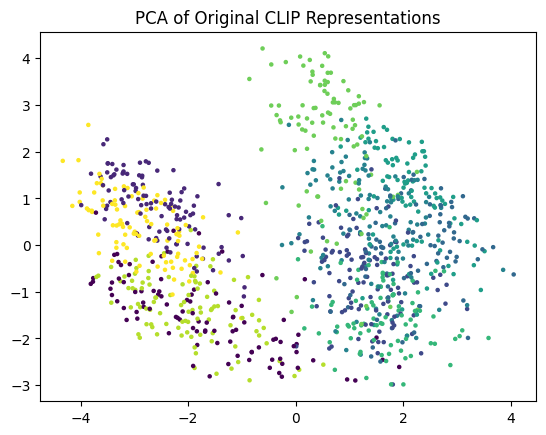

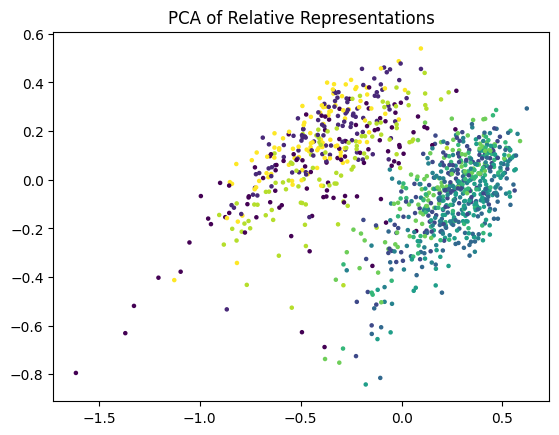

In [14]:
# PCA Visualization for Original and Relative Representations
pca = PCA(n_components=2)

# Use a subset of the training data (e.g., first 1000 samples) for visualization
subset_indices = np.arange(1000)
orig_subset = train_reps[subset_indices].numpy()
rel_subset = train_rel_reps[subset_indices].numpy()
labels_subset = train_labels[subset_indices].numpy()

# PCA for original CLIP representations
orig_2d = pca.fit_transform(orig_subset)
plt.figure()
plt.scatter(orig_2d[:, 0], orig_2d[:, 1], c=labels_subset, cmap='viridis', s=5)
plt.title("PCA of Original CLIP Representations")
# plt.savefig("results/pca_original.png")
plt.show()

# PCA for relative representations
pca_rel = PCA(n_components=2)
rel_2d = pca_rel.fit_transform(rel_subset)
plt.figure()
plt.scatter(rel_2d[:, 0], rel_2d[:, 1], c=labels_subset, cmap='viridis', s=5)
plt.title("PCA of Relative Representations")
# plt.savefig("results/pca_relative.png")
plt.show()